In [52]:
#Importing relevant libraries 
import io
import cv2
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [53]:
#Loading the training and testing datasets
train = r"C:\MRI-Dementia-Pred\train-00000-of-00001-c08a401c53fe5312.parquet"
test = r"C:\MRI-Dementia-Pred\test-00000-of-00001-44110b9df98c5585.parquet"

#Using provided categories of dementia status 
categories = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}
#Read the parquets using pandas library
data_train = pd.read_parquet(train)
data_test = pd.read_parquet(test)
data_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [54]:
#Function for extracting the images into a numpy array so that they can be more easily normalized later on.

def extract_and_transform(images_set):
    transformed_images = []
    for img_dict in images_set['image']:
        byte_string = img_dict['bytes']
        img = Image.open(io.BytesIO(byte_string)).convert('L')
        transformed_images.append(np.array(img))
    return transformed_images

def visualize_images(image_set, categories, limit=5):
    fig, axes = plt.subplots(1, limit, figsize=(15, 5))
    for i, (ax, (_, row)) in enumerate(zip(axes, image_set.iterrows())):
        # Extract image bytes and convert to a PIL Image
        byte_string = row['image']['bytes']
        img = Image.open(io.BytesIO(byte_string))
        
        # Get the label and category name
        label = row['label']
        category_name = categories[label]
        ax.imshow(img, cmap='gray')
        ax.set_title(category_name)
        ax.axis('off')
        
        if i + 1 == limit:
            break

    plt.tight_layout()
    plt.show()   

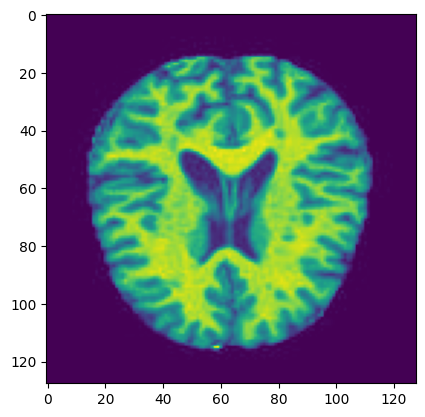

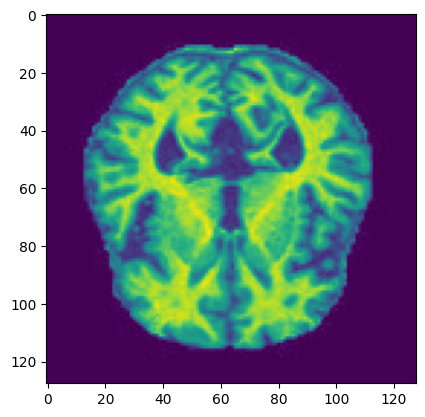

In [67]:
#Extract some images to determine if they have been successfully added
plt.figure()
plt.imshow(extract_and_transform(data_train)[0])
plt.figure()
plt.imshow(extract_and_transform(data_train)[1])

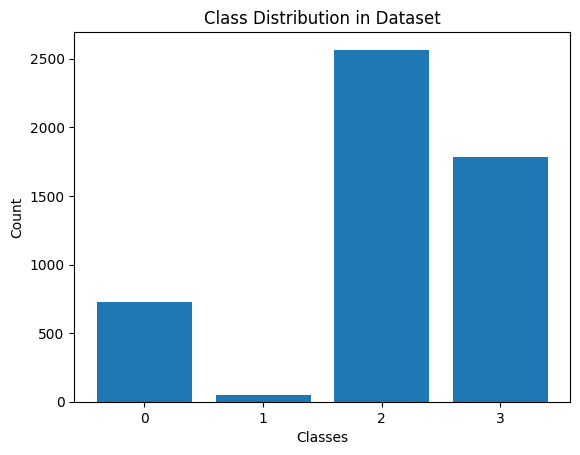

In [55]:
#Exploratory analysis: Determine the distribution amongst classes

# Convert labels from test and train datasets into arrays
y_test = np.array(data_test['label'])
y_train = np.array(data_train['label'])

# Calculate unique labels and their counts
unique, counts = np.unique(y_train, return_counts=True)

# Visualize the distribution of classes
plt.bar(unique, counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Dataset')
plt.xticks(unique)
plt.show()

From barplot above, insufficient quantities of different stages of dementia diagnosis. Therefore, we will clump dataset into either "Demented" or "Non-demented" for predictions.

Train set distribution:


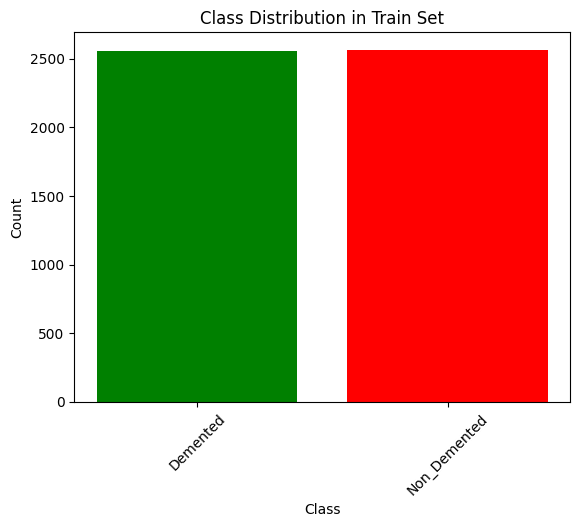

Test set distribution:


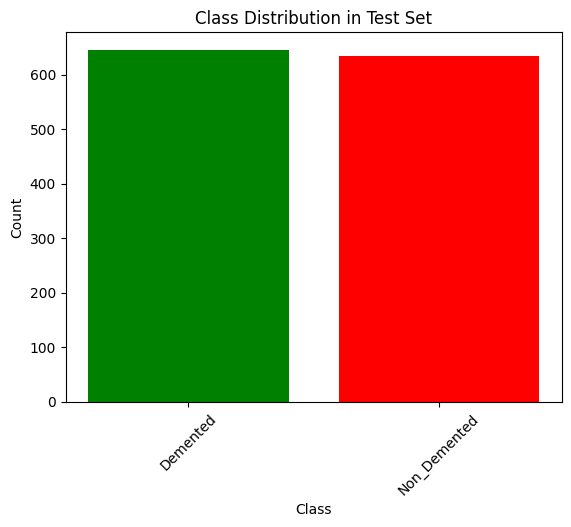

In [62]:
new_categories = {
    0: 'Demented',
    1: 'Demented',
    2: 'Non_Demented',
    3: 'Demented'
}

# Map the original labels to the new classes
data_train['new_label'] = data_train['label'].map(new_categories)
data_test['new_label'] = data_test['label'].map(new_categories)

# Visualize the new distribution
def show_distribution(dataset, title):
    unique, counts = np.unique(dataset['new_label'], return_counts=True)
    plt.bar(unique, counts, color=['green', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Show the distribution for train and test sets
print("Train set distribution:")
show_distribution(data_train, "Class Distribution in Train Set")

print("Test set distribution:")
show_distribution(data_test, "Class Distribution in Test Set")

In [57]:
from sklearn.preprocessing import StandardScaler

#Options to normalize or standardize images prior to CNN
def preprocess_images(data, normalize=True, standardize=True):
    images = []
    labels = []
    
    for _, row in data.iterrows():
        byte_string = row['image']['bytes']
        img = Image.open(io.BytesIO(byte_string)).convert('L')  # GRAYSCALE
        img_array = np.array(img, dtype=np.float32)
        
        # NORMALIZE
        if normalize:
            img_array /= 255.0
        
        images.append(img_array)
        labels.append(1 if row['new_label'] == 'Demented' else 0)  # Binary labels: 1 (Demented), 0 (Non_Demented)
    
    images = np.array(images)
    labels = np.array(labels)

    if standardize:
        scaler = StandardScaler()
        n_samples, h, w = images.shape
        images = images.reshape(n_samples, -1)  # Reshape to (samples, features)
        images = scaler.fit_transform(images)  # Standardize
        images = images.reshape(n_samples, h, w)  # Reshape back to original shape
    
    return images, labels

#Assemble train and test 
X_train, y_train = preprocess_images(data_train)
X_test, y_test = preprocess_images(data_test)

# Add channel dimension for CNN (grayscale)
X_train = X_train[..., np.newaxis]  # Shape: (n_samples, height, width, 1)
X_test = X_test[..., np.newaxis]    # Shape: (n_samples, height, width, 1)

# Verify processed data
print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (5120, 128, 128, 1)
Train labels shape: (5120,)
Test images shape: (1280, 128, 128, 1)
Test labels shape: (1280,)


In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.InputLayer(input_shape=(128, 128, 1)),  # Input layer for grayscale 128x128 images
    
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    
    layers.Flatten(),
    
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    
    
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,233 (16.35 MB)

 Trainable params: 4,287,233 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.6264 - loss: 0.6800 - val_accuracy: 0.7094 - val_loss: 0.5623
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.7320 - loss: 0.5425 - val_accuracy: 0.7680 - val_loss: 0.4844
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 234ms/step - accuracy: 0.7829 - loss: 0.4457 - val_accuracy: 0.7977 - val_loss: 0.4088
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 241ms/step - accuracy: 0.8515 - loss: 0.3299 - val_accuracy: 0.8477 - val_loss: 0.3235
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 247ms/step - accuracy: 0.9080 - loss: 0.2308 - val_accuracy: 0.8984 - val_loss: 0.2344
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 236ms/step - accuracy: 0.9350 - loss: 0.1546 - val_accuracy: 0.9312 - val_loss: 0.1851
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.9628 - loss: 0.1004 - val_accuracy: 0.9336 - val_loss: 0.1957
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.9701 - loss: 0

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9698 - loss: 0.0845
Test Loss: 0.09429474174976349
Test Accuracy: 0.9664062261581421


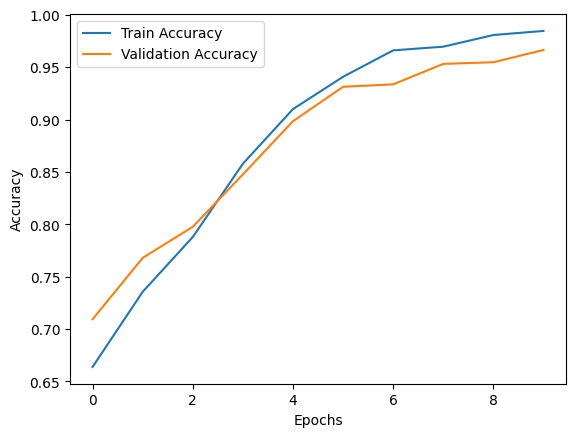

In [60]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


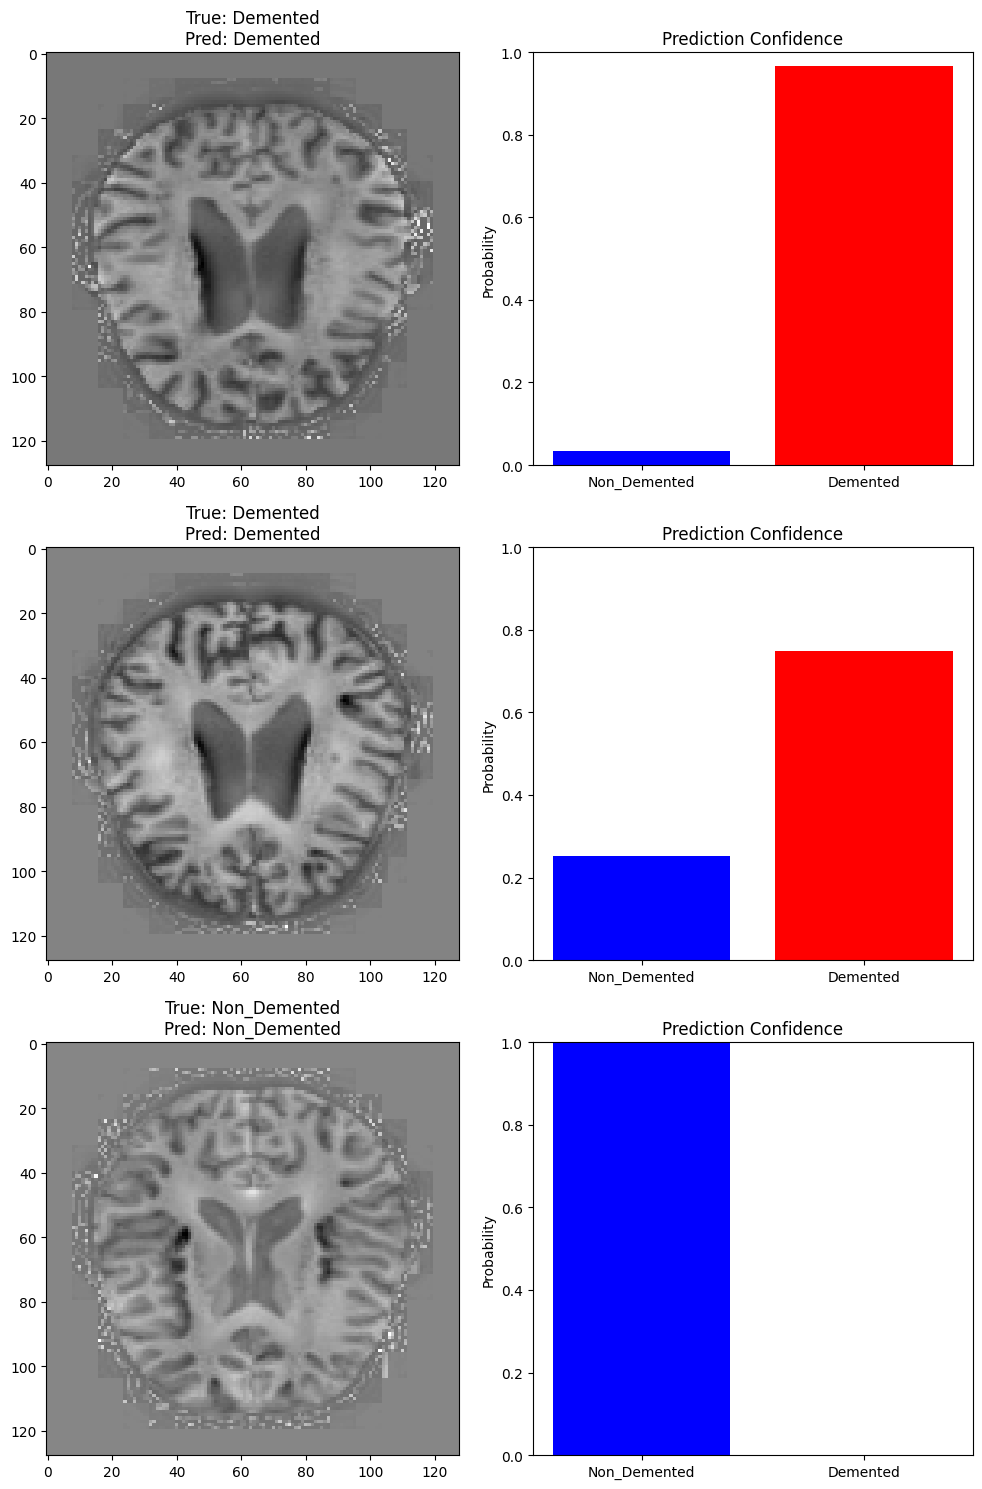

In [63]:
def visualize_predictions(model, X_test, y_test, categories, limit=3):
  
    predictions = model.predict(X_test)
    fig, axes = plt.subplots(limit, 2, figsize=(10, 5 * limit))
    
    for i in range(limit):
        img = X_test[i, :, :, 0]  
        pred_prob_demented = predictions[i]  
        if isinstance(pred_prob_demented, np.ndarray):
            pred_prob_demented = pred_prob_demented[0]
        
        pred_prob_nondemented = 1 - pred_prob_demented  # Probability for Non_Demented class
        
        true_label = categories[y_test[i]]  # True label
        predicted_label = categories[1 if pred_prob_demented > 0.5 else 0]  # Predicted label (thresholded at 0.5)
        ax_img = axes[i, 0]
        ax_img.imshow(img, cmap='gray')
        ax_img.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax_bar = axes[i, 1]
        ax_bar.bar(['Non_Demented', 'Demented'], [pred_prob_nondemented, pred_prob_demented], color=['blue', 'red'])
        ax_bar.set_ylim(0, 1)
        ax_bar.set_ylabel('Probability')
        ax_bar.set_title(f"Prediction Confidence")
    
    plt.tight_layout()
    plt.show()

categories = {0: 'Non_Demented', 1: 'Demented'}
visualize_predictions(model, X_test, y_test, categories)